### Data Manipulation

In [92]:
import sqlite3
import pandas as pd
import requests
import json
import numpy as np

In [2]:
con = sqlite3.connect('database.sqlite')
cursor = con.cursor()

In [14]:
matches_df = pd.read_sql("""SELECT Date, HomeTeam, AwayTeam, FTHG, FTAG, FTR
            FROM Matches
            WHERE Season = 2011""", con)

In [15]:
matches_df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,2011-11-27,Mainz,Bayern Munich,3,2,H
4,2012-02-18,Freiburg,Bayern Munich,0,0,D
...,...,...,...,...,...,...
987,2012-05-13,Sunderland,Man United,0,1,A
988,2012-05-13,Swansea,Liverpool,1,0,H
989,2012-05-13,Tottenham,Fulham,2,0,H
990,2012-05-13,West Brom,Arsenal,2,3,A


In [16]:
matches_df['Datetime'] = pd.to_datetime(matches_df['Date'])

In [25]:
# matches_df['DateUnix'] = (pd.to_datetime(matches_df['Date']).astype(int) / 10**9).astype(int)

In [34]:
matches_df['DateUnix'] = (pd.to_datetime([date + ' 17:00:00' for date in matches_df['Date']]).astype(int) / 10**9).astype(int)

In [35]:
matches_df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Datetime,DateUnix
0,2012-03-31,Nurnberg,Bayern Munich,0,1,A,2012-03-31,1333213200
1,2011-12-11,Stuttgart,Bayern Munich,1,2,A,2011-12-11,1323622800
2,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,2011-08-13,1313254800
3,2011-11-27,Mainz,Bayern Munich,3,2,H,2011-11-27,1322413200
4,2012-02-18,Freiburg,Bayern Munich,0,0,D,2012-02-18,1329584400
...,...,...,...,...,...,...,...,...
987,2012-05-13,Sunderland,Man United,0,1,A,2012-05-13,1336928400
988,2012-05-13,Swansea,Liverpool,1,0,H,2012-05-13,1336928400
989,2012-05-13,Tottenham,Fulham,2,0,H,2012-05-13,1336928400
990,2012-05-13,West Brom,Arsenal,2,3,A,2012-05-13,1336928400


In [37]:
matches_df.DateUnix[1]

1323622800

In [79]:
matches_df2 = pd.DataFrame()
matches_df2['team'] = pd.concat([matches_df.HomeTeam, matches_df.AwayTeam])
matches_df2.head()

,team
0,Nurnberg
1,Stuttgart
2,Wolfsburg
3,Mainz
4,Freiburg


In [94]:
df2 = pd.DataFrame()
df2['Team'] = pd.concat([matches_df['HomeTeam'], matches_df['AwayTeam']])
df2['Goals']=pd.concat([matches_df['FTHG'], matches_df['FTAG']])
df2['Goals'].groupby(df2['Team']).agg([np.sum])
winning_teams=[]
for i,j in enumerate(matches_df['FTR']):
    if j == 'H':
        winning_teams.append(matches_df['HomeTeam'][i])
    elif j == 'A':
        winning_teams.append(matches_df['AwayTeam'][i])
    else:
        continue
winning_series = pd.Series(winning_teams)
losing_teams=[]
for i,j in enumerate(matches_df['FTR']):
    if j == 'H':
        losing_teams.append(matches_df['AwayTeam'][i])
    elif j == 'A':
        losing_teams.append(matches_df['HomeTeam'][i])
    else:
        continue
losing_series = pd.Series(losing_teams)
print(losing_series.describe())
losing_series.value_counts()

count        729
unique        56
top       Wolves
freq          23
dtype: object


Wolves                23
Blackburn             23
Bolton                22
QPR                   21
FC Koln               20
Kaiserslautern        19
Karlsruhe             19
West Brom             17
Bochum                17
Wigan                 17
Hertha                17
Hansa Rostock         17
Nurnberg              16
Wolfsburg             16
Erzgebirge Aue        15
Sunderland            15
Swansea               15
Duisburg              15
Cottbus               15
Stoke                 15
Aachen                15
Norwich               15
Aston Villa           14
Werder Bremen         14
Fulham                14
Freiburg              14
Hamburg               14
Union Berlin          14
Liverpool             14
Ingolstadt            13
Mainz                 13
Dresden               13
Hoffenheim            13
Frankfurt FSV         13
Augsburg              12
Everton               12
Newcastle             11
Stuttgart             11
Munich 1860           11
Hannover              10


## Getting the Weather Data via API

In [67]:
BERLIN_LAT = 52.520008
BERLIN_LONG = 13.404954

In [46]:
# response = requests.get("https://api.darksky.net/forecast/6b2b218ae6efb7163c1faa7a0ec74930/37.8267,-122.4233/")
response = requests.get(f"https://api.darksky.net/forecast/6b2b218ae6efb7163c1faa7a0ec74930/{BERLIN_LAT},{BERLIN_LONG},255657600?exclude=currently,flags")

# Print the status code of the response.
print(response.status_code)

200


In [76]:
# previewing all weather statuses in the json file for a particular day
for hour in dict(response.json())['hourly']['data']:
        print(hour['icon'])

cloudy
partly-cloudy-night
cloudy
cloudy
partly-cloudy-night
cloudy
cloudy
partly-cloudy-day
cloudy
cloudy
cloudy
wind
snow
wind
wind
wind
snow
snow
snow
snow
snow
snow
snow
snow


In [80]:
def api_call(latitude, longitude, unix_time, key):
    URL = f"https://api.darksky.net/forecast/{key}/{latitude},{longitude},{unix_time}?exclude=currently,flags"
    response = requests.get(URL)
    return response.json()

def get_values_from_json(json, unix_time):
    for hour_dictionary in json['hourly']['data']:
        if hour_dictionary['time'] == unix_time:
            return (hour_dictionary['icon'], hour_dictionary['temperature'])
        
def make_new_columns(unix_times):
    LAT = '42.3601'
    LONG = '-71.0589'
    KEY = 'fd8c3437c8ea56907f93a08a8ecfcea4'
    icon_col = []
    temperature_col = []
    
    for unix_time in unix_times[:5]:
    # [:5] to limit to 5 API calls. Remove for actual calls.
        new_json = api_call(LAT, LONG, unix_time, KEY)
        json_values = get_values_from_json(new_json, unix_time)
        icon_col.append(json_values[0])
        temperature_col.append(json_values[1])
    return (icon_col, temperature_col)

### Testing the above code for 5 API calls

In [97]:
new_columns = make_new_columns(matches_df.DateUnix)

weather_col = new_columns[0]
temp_col = new_columns[1]

In [98]:
temp_col

[39.94, 36.93, 80.49, 48.94, 44.3]

In [99]:
test_df = matches_df.head()

In [100]:
test_df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Datetime,DateUnix
0,2012-03-31,Nurnberg,Bayern Munich,0,1,A,2012-03-31,1333213200
1,2011-12-11,Stuttgart,Bayern Munich,1,2,A,2011-12-11,1323622800
2,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,2011-08-13,1313254800
3,2011-11-27,Mainz,Bayern Munich,3,2,H,2011-11-27,1322413200
4,2012-02-18,Freiburg,Bayern Munich,0,0,D,2012-02-18,1329584400


In [101]:
test_df['weather'] = weather_col
test_df['temperature'] = temp_col
test_df

/Users/flatironschooldc2/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/flatironschooldc2/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Datetime,DateUnix,weather,temperature
0,2012-03-31,Nurnberg,Bayern Munich,0,1,A,2012-03-31,1333213200,cloudy,39.94
1,2011-12-11,Stuttgart,Bayern Munich,1,2,A,2011-12-11,1323622800,clear-day,36.93
2,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,2011-08-13,1313254800,clear-day,80.49
3,2011-11-27,Mainz,Bayern Munich,3,2,H,2011-11-27,1322413200,partly-cloudy-day,48.94
4,2012-02-18,Freiburg,Bayern Munich,0,0,D,2012-02-18,1329584400,clear-day,44.30


In [102]:

test_df['rain'] = test_df['weather'].apply(lambda x: "rain" in x)
test_df.head()

/Users/flatironschooldc2/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Datetime,DateUnix,weather,temperature,rain
0,2012-03-31,Nurnberg,Bayern Munich,0,1,A,2012-03-31,1333213200,cloudy,39.94,False
1,2011-12-11,Stuttgart,Bayern Munich,1,2,A,2011-12-11,1323622800,clear-day,36.93,False
2,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,2011-08-13,1313254800,clear-day,80.49,False
3,2011-11-27,Mainz,Bayern Munich,3,2,H,2011-11-27,1322413200,partly-cloudy-day,48.94,False
4,2012-02-18,Freiburg,Bayern Munich,0,0,D,2012-02-18,1329584400,clear-day,44.30,False


## Data Visualization

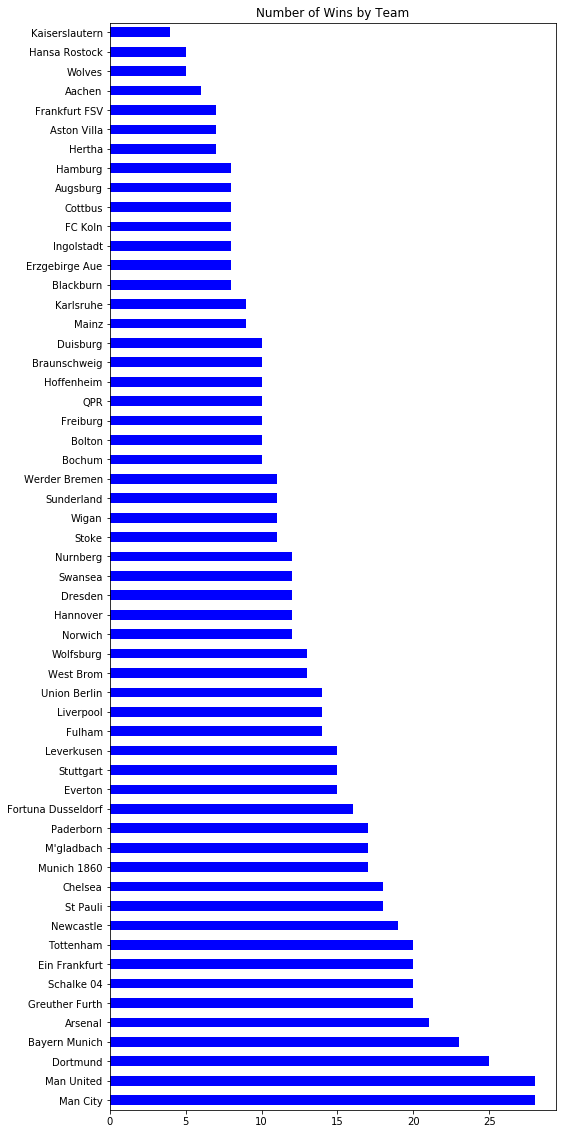

In [104]:
winning_series.value_counts().plot(kind='barh',figsize=(8,20),title='Number of Wins by Team',color='blue');

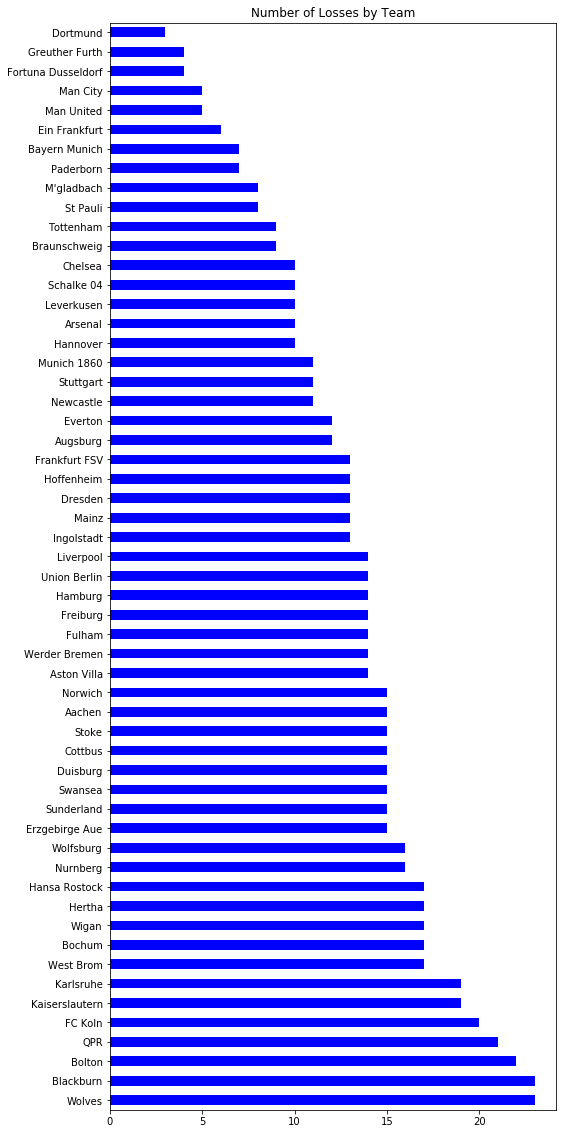

In [106]:
losing_series.value_counts().plot(kind='barh',figsize=(8,20),title='Number of Losses by Team',color='blue');